In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import imutils
import ray

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Flatten, Activation, Dense, MaxPooling2D

In [3]:
# Initialize Ray with a specific number of cores (e.g., 4)
ray.init(num_cpus=4)

2024-11-08 21:13:27,404	INFO worker.py:1777 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.12.4
Ray version:,2.37.0
Dashboard:,http://127.0.0.1:8265


In [5]:
image_dir = "D:/coaLab/brain_tumor_dataset/"
augmented_data_path = '../augmented/working/augmented-images/'

In [7]:
# Create necessary directories
os.makedirs(augmented_data_path + 'yes', exist_ok=True)
os.makedirs(augmented_data_path + 'no', exist_ok=True)

In [9]:
@ray.remote
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i = 0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir, save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break

In [11]:
ray.get([
    augment_data.remote(image_dir + 'yes', 6, augmented_data_path + 'yes'),
    augment_data.remote(image_dir + 'no', 9, augmented_data_path + 'no')
])

(pid=25732) 2024-11-08 21:14:20.192709: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


[None, None]

In [13]:
@ray.remote
def crop_brain_contour(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.title('Cropped Image')
        plt.show()

    return new_image

In [15]:
@ray.remote
def load_data(dir_list, image_size):
    X, y = [], []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = ray.get(crop_brain_contour.remote(image))
            image = cv2.resize(image, (image_width, image_height), interpolation=cv2.INTER_CUBIC)
            image = image / 255.0
            X.append(image)
            y.append([1] if directory[-3:] == 'yes' else [0])

    X = np.array(X)
    y = np.array(y)
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y
# Load data in parallel
augmented_yes = augmented_data_path + 'yes'
augmented_no = augmented_data_path + 'no'
IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = ray.get(load_data.remote([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT)))

(load_data pid=3008) Number of examples is: 2064
(load_data pid=3008) X shape is: (2064, 240, 240, 3)
(load_data pid=3008) y shape is: (2064, 1)


In [17]:
@ray.remote
def split_data(X, y, test_size=0.2):
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = ray.get(split_data.remote(X, y, test_size=0.3))

print("number of training examples =", X_train.shape[0])
print("number of validation examples =", X_val.shape[0])
print("number of test examples =", X_test.shape[0])

number of training examples = 1444
number of validation examples = 310
number of test examples = 310


In [19]:
@ray.remote
def build_model(input_shape):
    X_input = Input(input_shape)
    X = ZeroPadding2D((2, 2))(X_input)
    X = Conv2D(32, (7, 7), strides=(1, 1))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((4, 4))(X)
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=X_input, outputs=X)
    return model

# Build and compile model
model = ray.get(build_model.remote((IMG_WIDTH, IMG_HEIGHT, 3)))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

(build_model pid=3008) 2024-11-08 21:24:28.007280: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(build_model pid=3008) To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 244, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 238, 238, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 111392)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       111,393 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,257 (454.13 KB)

 Trainable params: 116,193 (453.88 KB)

 Non-trainable params: 64 (256.00 B)

In [21]:
model = ray.get(build_model.remote((IMG_WIDTH, IMG_HEIGHT, 3)))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 244, 244, 3)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 238, 238, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 111392)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │       111,393 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,257 (454.13 KB)

 Trainable params: 116,193 (453.88 KB)

 Non-trainable params: 64 (256.00 B)

In [23]:
# Train the model (without Ray parallelization since TensorFlow manages its own threading)
history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=22, validation_data=(X_val, y_val))

Epoch 1/22
24/46 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5657 - loss: 6.7021

(raylet) [2024-11-08 21:27:30,138 E 33104 9312] (raylet.exe) agent_manager.cc:83: The raylet exited immediately because one Ray agent failed, agent_name = dashboard_agent/15724.
(raylet) The raylet fate shares with the agent. This can happen because
(raylet) - The version of `grpcio` doesn't follow Ray's requirement. Agent can segfault with the incorrect `grpcio` version. Check the grpcio version `pip freeze | grep grpcio`.
(raylet) - The agent failed to start because of unexpected error or port conflict. Read the log `cat /tmp/ray/session_latest/logs/{dashboard_agent|runtime_env_agent}.log`. You can find the log file structure here https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#logging-directory-structure.
(raylet) - The agent is killed by the OS (e.g., out of memory).


(raylet) The node with node id: c93c0cb1a6648e35e7e957fa8e6819bb63ace58dfdc01c31277cc77b and address: 127.0.0.1 and node name: 127.0.0.1 has been marked dead because the detector has missed too many heartbeats from it. This can happen when a 	(1) raylet crashes unexpectedly (OOM, etc.) 
	(2) raylet has lagging heartbeats due to slow network or busy workload.
25/46 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.5661 - loss: 6.6205

(raylet) *** SIGSEGV received at time=1731081451 ***
(raylet)     @   00007FF723CF51F9  (unknown)  (unknown)
(raylet) [2024-11-08 21:27:31,549 E 33104 20640] (raylet.exe) logging.cc:440: *** SIGSEGV received at time=1731081451 ***
(raylet) [2024-11-08 21:27:31,549 E 33104 20640] (raylet.exe) logging.cc:440:     @   00007FF723CF51F9  (unknown)  (unknown)


46/46 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.5796 - loss: 5.2907 - val_accuracy: 0.5097 - val_loss: 1.3803
Epoch 2/22
46/46 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.7264 - loss: 1.1684 - val_accuracy: 0.6323 - val_loss: 0.7304
Epoch 3/22
46/46 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8470 - loss: 0.4558 - val_accuracy: 0.6774 - val_loss: 0.6922
Epoch 4/22
46/46 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.8370 - loss: 0.4806 - val_accuracy: 0.5194 - val_loss: 1.8574
Epoch 5/22
46/46 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8407 - loss: 0.6186 - val_accuracy: 0.6226 - val_loss: 1.4201
Epoch 6/22
46/46 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8306 - loss: 0.5971 - val_accuracy: 0.7000 - val_loss: 1.0867
Epoch 7/22
46/46 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.8936 - loss: 0.3722 - val_accuracy: 0.6387 - val_loss: 2.0159
Epoch 8/22
46/46 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9093 - loss: 0.2559 - val_accuracy: 0.7806 - val_loss: 0.7304
E

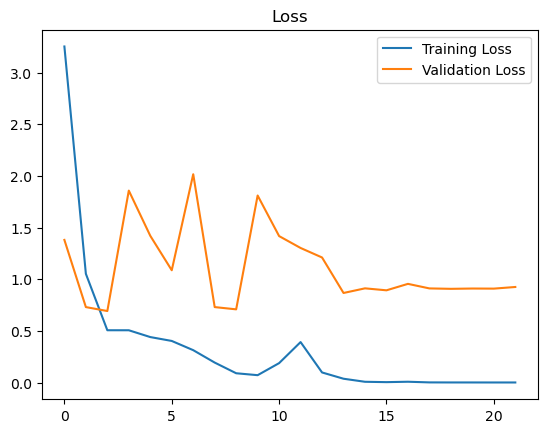

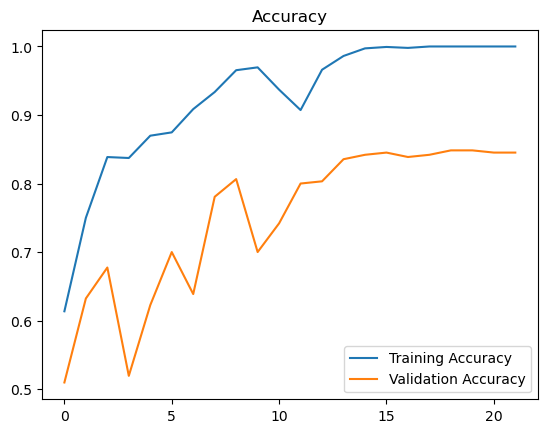

In [25]:
def plot_metrics(history):
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

plot_metrics(history)

In [31]:
import time

# Temporarily remove @ray.remote for sequential execution testing
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i = 0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir, save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break

def load_data(dir_list, image_size):
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            image = image / 255.0
            X.append(image)
            y.append([1] if directory[-3:] == 'yes' else [0])
                
    X = np.array(X)
    y = np.array(y)
    
    X, y = shuffle(X, y)
    return X, y

def split_data(X, y, test_size=0.2):
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    return X_train, y_train, X_val, y_val, X_test, y_test

def build_model(input_shape):
    X_input = Input(input_shape)
    X = ZeroPadding2D((2, 2))(X_input)
    X = Conv2D(32, (7, 7), strides=(1, 1))(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((4, 4))(X)
    X = MaxPooling2D((4, 4))(X)
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=X_input, outputs=X)
    return model

# Start timing
start_time = time.time()

# Sequential data augmentation and loading
augment_data(image_dir + 'yes', 6, augmented_data_path + 'yes')
augment_data(image_dir + 'no', 9, augmented_data_path + 'no')
X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

# Split data and build model
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)
model = build_model((IMG_WIDTH, IMG_HEIGHT, 3))

# Compile and train model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=22, validation_data=(X_val, y_val))

# End timing and print sequential execution time
sequential_time = time.time() - start_time
print(f"Sequential execution time: {sequential_time:.2f} seconds")


NameError: name 'listdir' is not defined

In [27]:
import time

# Initialize Ray and start timing
ray.init(num_cpus=4)
start_time = time.time()

# Parallel data augmentation and loading
ray.get([
    augment_data.remote(image_dir+'yes', 6, augmented_data_path+'yes'),
    augment_data.remote(image_dir+'no', 9, augmented_data_path+'no')
])
X, y = ray.get(load_data.remote([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT)))

# Parallel data split
X_train, y_train, X_val, y_val, X_test, y_test = ray.get(split_data.remote(X, y, test_size=0.3))

# Build and compile model (sequential, as TensorFlow handles threading internally)
model = ray.get(build_model.remote((IMG_WIDTH, IMG_HEIGHT, 3)))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_parallel = model.fit(x=X_train, y=y_train, batch_size=32, epochs=22, validation_data=(X_val, y_val))

# Record end time for parallel execution
parallel_time = time.time() - start_time
print(f"Parallel execution time: {parallel_time:.2f} seconds")

# Calculate speedup
speedup = sequential_time / parallel_time
print(f"Speedup achieved with parallel execution: {speedup:.2f}x")


RuntimeError: Maybe you called ray.init twice by accident? This error can be suppressed by passing in 'ignore_reinit_error=True' or by calling 'ray.shutdown()' prior to 'ray.init()'.

In [ ]:
import matplotlib.pyplot as plt

# Accuracy comparison plot
plt.figure(figsize=(12, 5))

# Sequential version accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy - Sequential')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy - Sequential')
plt.title('Sequential CNN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Parallel version accuracy
plt.subplot(1, 2, 2)
plt.plot(history_parallel.history['accuracy'], label='Train Accuracy - Parallel')
plt.plot(history_parallel.history['val_accuracy'], label='Validation Accuracy - Parallel')
plt.title('Parallel CNN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Plotting Speedup
plt.figure(figsize=(8, 5))
plt.bar(['Sequential Time', 'Parallel Time'], [sequential_time, parallel_time], color=['blue', 'green'])
plt.title(f"Execution Time Comparison\nSpeedup = {speedup:.2f}x")
plt.ylabel('Time (seconds)')
plt.show()
